In [26]:
import os
import numpy as np
import pandas as pd
import cv2
data_path = '../input/ckplus-dataset/CK+48/'
data_dir_list = os.listdir(data_path)

img_data_list=[]
for dataset in data_dir_list:
    img_list=os.listdir(data_path+'/'+ dataset)
    for img in img_list:
        input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
        input_img_resize=cv2.resize(input_img,(150,150))
        img_data_list.append(input_img_resize)
        
img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data = img_data/255
img_data.shape

(981, 150, 150, 3)

In [27]:
num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

labels[0:29]=0 
labels[30:58]=1 
labels[59:90]=2 
labels[91:121]=3 
labels[122:151]=4 
labels[152:182]=5 
labels[183:]=6 

names = ['ANGRY','DISGUST','FEAR','HAPPY','NEUTRAL','SAD','SURPRISE']

def getLabel(id):
    return ['ANGRY','DISGUST','FEAR','HAPPY','NEUTRAL','SAD','SURPRISE'][id]

In [28]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import keras
from keras.utils import np_utils
Y = np_utils.to_categorical(labels, 7)
x,y = shuffle(img_data,Y)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15)
x_test=X_test

In [29]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from keras.applications import InceptionResNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf


In [30]:
pre_trained_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(150,150,3))

In [31]:
pre_trained_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_609 (Conv2D)             (None, 74, 74, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_609 (BatchN (None, 74, 74, 32)   96          conv2d_609[0][0]                 
__________________________________________________________________________________________________
activation_609 (Activation)     (None, 74, 74, 32)   0           batch_normalization_609[0][0]    
________________________________________________________________________________

__________________________________________________________________________________________________
batch_normalization_739 (BatchN (None, 7, 7, 160)    480         conv2d_739[0][0]                 
__________________________________________________________________________________________________
activation_739 (Activation)     (None, 7, 7, 160)    0           batch_normalization_739[0][0]    
__________________________________________________________________________________________________
conv2d_737 (Conv2D)             (None, 7, 7, 192)    208896      block17_13_ac[0][0]              
__________________________________________________________________________________________________
conv2d_740 (Conv2D)             (None, 7, 7, 192)    215040      activation_739[0][0]             
__________________________________________________________________________________________________
batch_normalization_737 (BatchN (None, 7, 7, 192)    576         conv2d_737[0][0]                 
__________

In [37]:
last_layer = pre_trained_model.get_layer('block17_20_mixed')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 384)


In [38]:
from tensorflow.keras.optimizers import Adam
x = tf.keras.layers.Conv2D(6, (5, 5),padding='same', activation = 'relu')(last_output)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)  
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)                  
x = layers.Dense  (7, activation='softmax')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = Adam(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [39]:
train_datagen = ImageDataGenerator(rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode='nearest')


train_generator = train_datagen.flow(X_train,y_train,batch_size = 8)   

In [40]:
from keras import callbacks

filepath="Best1.hdf5"
checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss',save_best_only=True, mode='min')
callbacks_list = [checkpoint]
history = model.fit_generator(
            train_generator,
            epochs = 100,validation_data=(x_test,y_test),callbacks=callbacks_list)

Epoch 1/100
105/105 [==============================] - 14s 138ms/step - loss: 1.0754 - accuracy: 0.7455 - val_loss: 0.6365 - val_accuracy: 0.8581
Epoch 2/100
105/105 [==============================] - 12s 115ms/step - loss: 0.7696 - accuracy: 0.8055 - val_loss: 0.5287 - val_accuracy: 0.8581
Epoch 3/100
105/105 [==============================] - 12s 114ms/step - loss: 0.7102 - accuracy: 0.8055 - val_loss: 0.4681 - val_accuracy: 0.8581
Epoch 4/100
105/105 [==============================] - 11s 108ms/step - loss: 0.7034 - accuracy: 0.8055 - val_loss: 0.4380 - val_accuracy: 0.8581
Epoch 5/100
105/105 [==============================] - 9s 90ms/step - loss: 0.6467 - accuracy: 0.8055 - val_loss: 0.4642 - val_accuracy: 0.8581
Epoch 6/100
105/105 [==============================] - 10s 92ms/step - loss: 0.6493 - accuracy: 0.8055 - val_loss: 85.8358 - val_accuracy: 0.8581
Epoch 7/100
105/105 [==============================] - 9s 88ms/step - loss: 0.6090 - accuracy: 0.8055 - val_loss: 4.5209 - val

105/105 [==============================] - 10s 93ms/step - loss: 0.3111 - accuracy: 0.8643 - val_loss: 0.4320 - val_accuracy: 0.8919
Epoch 58/100
105/105 [==============================] - 10s 96ms/step - loss: 0.3427 - accuracy: 0.8607 - val_loss: 0.3410 - val_accuracy: 0.8919
Epoch 59/100
105/105 [==============================] - 9s 88ms/step - loss: 0.3343 - accuracy: 0.8595 - val_loss: 0.3479 - val_accuracy: 0.8919
Epoch 60/100
105/105 [==============================] - 9s 87ms/step - loss: 0.3392 - accuracy: 0.8643 - val_loss: 0.3367 - val_accuracy: 0.8919
Epoch 61/100
105/105 [==============================] - 9s 90ms/step - loss: 0.3225 - accuracy: 0.8631 - val_loss: 0.4527 - val_accuracy: 0.8716
Epoch 62/100
105/105 [==============================] - 9s 88ms/step - loss: 0.3476 - accuracy: 0.8499 - val_loss: 0.4032 - val_accuracy: 0.8919
Epoch 63/100
105/105 [==============================] - 10s 92ms/step - loss: 0.3409 - accuracy: 0.8619 - val_loss: 0.4091 - val_accuracy: 0.

<Figure size 432x288 with 0 Axes>

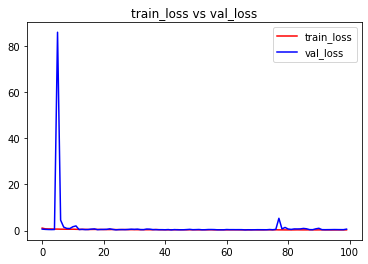

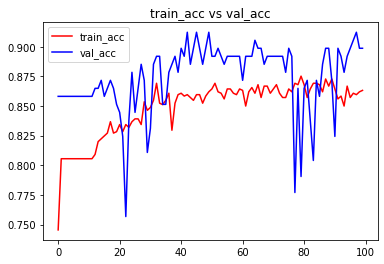

<Figure size 432x288 with 0 Axes>

In [41]:
import matplotlib.pyplot as plt
train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.legend()
plt.figure()

Test Loss: 0.28968915343284607
Test accuracy: 0.912162184715271
[[5.0865495e-08 4.9143459e-08 7.5998678e-08 2.8657253e-08 1.4947484e-06
  4.9412245e-07 9.9999774e-01]]
[6]
[[0. 0. 0. 0. 0. 0. 1.]]


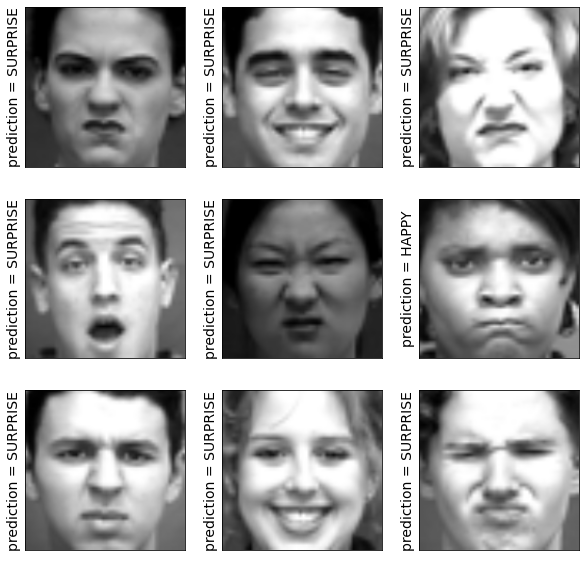

In [42]:
model.load_weights("Best1.hdf5")
score = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

test_image = X_test[0:1]

print(model.predict(test_image))
print(model.predict(test_image).argmax(axis=-1))
print(y_test[0:1])

res = model.predict(X_test[9:18]).argmax(axis=-1)
plt.figure(figsize=(10, 10))

for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_test[i],cmap=plt.get_cmap('gray'))
    plt.gca().get_xaxis().set_ticks([])
    plt.gca().get_yaxis().set_ticks([])
    plt.ylabel('prediction = %s' % getLabel(res[i]), fontsize=14)
# show the plot
plt.show()